# Example 06 - Wideband Modulations Signal Detector
This notebook walks through the process of using TorchSig to instantiate the WBSig53 dataset, load a pretrained DETR model, train the DETR model for signal detection, and evaluate its performance through plots and mean average precision (mAP) scores.

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [2]:
import time
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchmetrics.detection import MeanAveragePrecision

import torchsig
import torchsig.transforms as ST
from torchsig.datasets.wideband_sig53 import WidebandSig53

----
### Instantiate WBSig53 Dataset
Here, we instantiate the WBSig53 dataset for training and validation. Please see example notebook 03 for more details on WBSig53. If you plan to compare your results with the baseline performance metrics, please use the impaired datasets by setting `impaired = True`.

In [2]:
# Specify WidebandSig53 Options
root = 'wideband_sig53/'
train = True
impaired = False
fft_size = 512
num_classes = 1

transform = ST.Compose([
    ST.Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode='complex'),
    ST.Normalize(norm=np.inf, flatten=True),
])

target_transform = ST.Compose([
    ST.DescToBBoxSignalDict(),
])

# Instantiate the training WidebandSig53 Dataset
wideband_sig53_train = WidebandSig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    regenerate=False,
    use_signal_data=True,
    gen_batch_size=1,
    use_gpu=True,
)

# Instantiate the validation WidebandSig53 Dataset
train = False
wideband_sig53_val = WidebandSig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    regenerate=False,
    use_signal_data=True,
    gen_batch_size=1,
    use_gpu=True,
)


# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_sig53_val))
data, label = wideband_sig53_val[idx]
print("Training Dataset length: {}".format(len(wideband_sig53_train)))
print("Validation Dataset length: {}".format(len(wideband_sig53_val)))
print("Data shape: {}".format(data.shape))
print("Label: {}".format(label))

Existing data found, skipping data generation
Existing data found, skipping data generation
Training Dataset length: 25000
Validation Dataset length: 25000
Data shape: (2, 512, 512)
Label: {'labels': tensor([0, 0, 0]), 'boxes': tensor([[0.5000, 0.2834, 1.0000, 0.3652],
        [0.5000, 0.6327, 1.0000, 0.0589],
        [0.5000, 0.8892, 1.0000, 0.0948]])}


----
### Format Dataset for Training
Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataloaders
train_dataloader = DataLoader(
    dataset=wideband_sig53_train,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
)

val_dataloader = DataLoader(
    dataset=wideband_sig53_val,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
)

----
### Instantiate Supported TorchSig Model
Below, we load a pretrained DETR-B0-Nano model, and then conform it to a PyTorch LightningModule for training.

In [4]:
model = torchsig.models.detr_b0_nano(
    pretrained=True,
    path="detr_b0_nano.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
class ExampleDETR(pl.LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleDETR, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader
        self.loss_fn = torchsig.models.spectrogram_models.detr.SetCriterion()
        
        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size
        
    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        return self.data_loader
    
    def training_step(self, batch, _):
        x, y = batch
        x = torch.stack([torch.as_tensor(xi, device="cuda") for xi in x], dim=0)
        y_hat = self.forward(x)
        loss_vals = self.loss_fn(y_hat, y)
        loss = self.loss_fn.weight_dict["loss_ce"] * loss_vals["loss_ce"] + \
            self.loss_fn.weight_dict["loss_bbox"] * loss_vals["loss_bbox"] + \
            self.loss_fn.weight_dict["loss_giou"] * loss_vals["loss_giou"]
        return {'loss':loss}
    
    def val_dataloader(self):
        return self.val_data_loader
    
    def validation_step(self, batch, _):
        x, y = batch
        x = torch.stack([torch.as_tensor(xi, device="cuda") for xi in x], dim=0)
        y_hat = self.forward(x)
        loss_vals = self.loss_fn(y_hat, y)
        loss = self.loss_fn.weight_dict["loss_ce"] * loss_vals["loss_ce"] + \
            self.loss_fn.weight_dict["loss_bbox"] * loss_vals["loss_bbox"] + \
            self.loss_fn.weight_dict["loss_giou"] * loss_vals["loss_giou"]
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        val_loss_mean = sum([o['val_loss'] for o in outputs]) / len(outputs)
        self.log('val_loss', val_loss_mean, prog_bar=True)
        
example_model = ExampleDETR(model, train_dataloader, val_dataloader)

----
### Train the Model
To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.

In [ ]:
# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

# Create and fit trainer
epochs = 50
trainer = pl.Trainer(max_epochs=epochs, callbacks=checkpoint_callback, accelerator='gpu', devices=1)
trainer.fit(example_model)

----
### Evaluate the Trained Model
Once the network is fully trained, we load the best checkpoint and then infer over a few random samples, inspecting the performance through plots.

In [22]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint['state_dict'])
example_model = example_model.eval()

In [10]:
preds = {}
data_collection = {}
label_collection = {}
results_collection = {}

threshold = 0.8
fft_size = 512

num_eval = 6
for p in range(num_eval):
    # Retrieve data
    idx = np.random.randint(len(wideband_sig53_val))
    data, label = wideband_sig53_val[idx]
    data_collection[p] = data
    
    # Infer
    with torch.no_grad():
        data = torch.from_numpy(np.expand_dims(data,0)).float()
        data = data.cuda() if torch.cuda.is_available() else data
        pred = example_model(data)
    preds[p] = pred
    
    # Convert output to detections dataframe
    component_num = 0
    column_names = ["DetectionIdx", "Probability", "CenterTimePixel", "DurationPixel", "CenterFreqPixel", "BandwidthPixel", "Class"]
    detected_signals_df = pd.DataFrame(columns = column_names)
    
    # Loop over the number of objects DETR outputs
    for obj_idx in range(pred['pred_logits'].shape[1]):
        probs = pred['pred_logits'][0][obj_idx].softmax(-1)
        max_prob = probs.max().cpu().detach().numpy()
        max_class = probs.argmax().cpu().detach().numpy()
        
        # If max class is not the last class for no object, interpret values
        if max_class != (pred['pred_logits'].shape[2] - 1) and max_prob > threshold:
            center_time = pred['pred_boxes'][0][obj_idx][0]
            center_freq = pred['pred_boxes'][0][obj_idx][1]
            duration = pred['pred_boxes'][0][obj_idx][2]
            bandwidth = pred['pred_boxes'][0][obj_idx][3]
        
            # Save to dataframe
            detected_signals_df.at[component_num,"DetectionIdx"] = component_num
            detected_signals_df.at[component_num,"Probability"] = max_prob
            detected_signals_df.at[component_num,"CenterTimePixel"] = center_time.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"DurationPixel"] = duration.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"CenterFreqPixel"] = center_freq.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"BandwidthPixel"] = bandwidth.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"Class"] = max_class
            component_num += 1

    # Save to results collection
    results_collection[p] = detected_signals_df
    
    # Convert label to labels dataframe
    component_num = 0
    labels_df = pd.DataFrame(columns = column_names)
    
    for label_obj_idx in range(len(label['labels'])):
        center_time = label["boxes"][label_obj_idx][0]
        center_freq = label["boxes"][label_obj_idx][1]
        duration = label["boxes"][label_obj_idx][2]
        bandwidth = label["boxes"][label_obj_idx][3]
        class_name = label["labels"][label_obj_idx]

        # Save to dataframe
        labels_df.at[component_num,"DetectionIdx"] = component_num
        labels_df.at[component_num,"Probability"] = 1.0
        labels_df.at[component_num,"CenterTimePixel"] = center_time * fft_size
        labels_df.at[component_num,"DurationPixel"] = duration * fft_size
        labels_df.at[component_num,"CenterFreqPixel"] = center_freq * fft_size
        labels_df.at[component_num,"BandwidthPixel"] = bandwidth * fft_size
        labels_df.at[component_num,"Class"] = class_name
        component_num += 1

    # Save to label collection
    label_collection[p] = labels_df

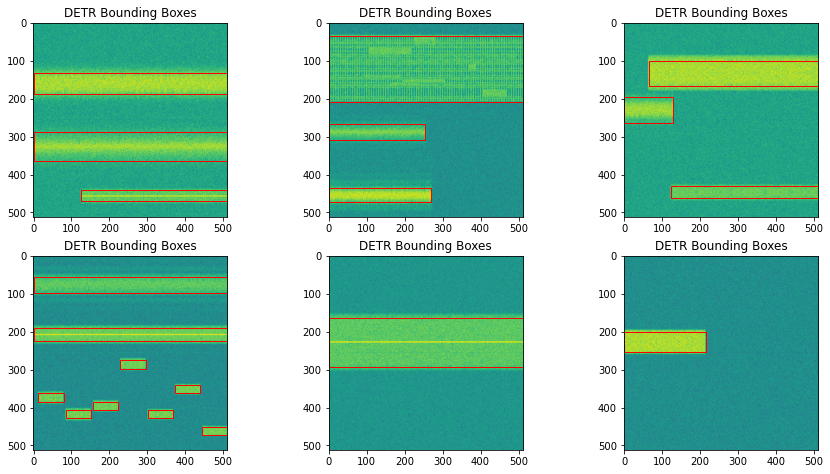

In [11]:
include_annotation = False

plt.figure(figsize=(15, 25))
for i in range(num_eval):
    ax = plt.subplot(num_eval,3,i+1)
    
    # Convert complex spectrogram to magnitude for plotting
    data_plot = np.squeeze(data_collection[i])
    data_plot = data_plot[0]**2 + data_plot[1]**2
    data_plot = 20*np.log10(data_plot)

    # Retrieve individual label
    ax.imshow(data_plot)
    for sig_idx in range(results_collection[i].shape[0]):
        rect = mpl.patches.Rectangle(
            (results_collection[i].iloc[sig_idx]["CenterTimePixel"]-results_collection[i].iloc[sig_idx]["DurationPixel"]/2,
             results_collection[i].iloc[sig_idx]["CenterFreqPixel"]-results_collection[i].iloc[sig_idx]["BandwidthPixel"]/2),
            results_collection[i].iloc[sig_idx]["DurationPixel"],
            results_collection[i].iloc[sig_idx]["BandwidthPixel"],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        if include_annotation:
            ax.annotate(
                "{:.1f}%".format(results_collection[i].iloc[sig_idx]["Probability"]*100), 
                (
                    results_collection[i].iloc[sig_idx]["CenterTimePixel"]+results_collection[i].iloc[sig_idx]["DurationPixel"]/2, 
                    results_collection[i].iloc[sig_idx]["CenterFreqPixel"]-results_collection[i].iloc[sig_idx]["BandwidthPixel"]/2
                ), 
                color='w', 
                weight='bold', 
                fontsize=8, 
                ha='right', 
                va='bottom',
             )
        
    plt.title("DETR Bounding Boxes")
plt.show()

----
### Compute the Mean Average Precision
As a final evaluation technique, we use the TorchMetrics's `MeanAveragePrecision` metric for computing the mAP. Please note that the TorchMetrics mAP computation is fairly slow, but it is the recommended tool for comparing to the performance baselines we provide.

In [7]:
mAP_metric = MeanAveragePrecision(class_metrics=False)

fft_size = 512
batch_size = 32
num_eval = len(wideband_sig53_val)
data_idx = 0

fp16 = True

model = model.eval().cuda()
if fp16:
    # Note: only the backbone supports fp16 precision at this time
    model.backbone = model.backbone.half()
    model.conv = model.conv.half()
    model.transformer = model.transformer.float()
    model.linear_class = model.linear_class.float()
    model.linear_bbox = model.linear_bbox.float()
else:
    model.backbone = model.backbone.float()
    model.conv = model.conv.float()
    model.transformer = model.transformer.float()
    model.linear_class = model.linear_class.float()
    model.linear_bbox = model.linear_bbox.float()

for curr_batch in tqdm(range(num_eval // batch_size)):
    # Create batch
    batch = np.zeros((batch_size, 2, fft_size, fft_size))
    label_batch = []
    for batch_element in range(batch_size):
        # Retrieve data
        idx = data_idx if num_eval == len(wideband_sig53_val) else np.random.randint(len(wideband_sig53_val))
        data_idx += 1
        data, label = wideband_sig53_val[idx]
        batch[batch_element,:] = data
        label_batch.append(label)
    
    # Infer
    with torch.no_grad():
        model_input = torch.from_numpy(batch)
        model_input = model_input.cuda() if torch.cuda.is_available() else model_input
        if fp16:
            x = model.backbone(model_input.half())
            h = model.conv(x)
            h = model.transformer(h.float()).float()
            preds = {
                'pred_logits': model.linear_class(h), 
                'pred_boxes': model.linear_bbox(h).sigmoid()
            }
        else:
            preds = model(model_input.float())
        
    # Format the predictions to match the torchmetrics input format
    map_preds = torchsig.models.spectrogram_models.detr.format_preds(preds)
    map_targets = torchsig.models.spectrogram_models.detr.format_targets(label_batch)
    mAP_score = mAP_metric.update(map_preds, map_targets)
    
# Calc mAP
print("Computing metrics...")
start_time = time.time()
mAP_dict = mAP_metric.compute()
mAP_score = float(mAP_dict['map'].numpy())
print("Done computing metrics in {:.2f}s".format(time.time() - start_time))

print("mAP: {}".format(mAP_score))
mAP_dict

100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Computing metrics...
Done computing metrics in 21.20s
mAP: 0.9502255320549011


{'map': tensor(0.9502),
 'map_50': tensor(0.9901),
 'map_75': tensor(0.9895),
 'map_small': tensor(0.9071),
 'map_medium': tensor(0.9442),
 'map_large': tensor(0.9689),
 'mar_1': tensor(0.2776),
 'mar_10': tensor(0.9523),
 'mar_100': tensor(0.9662),
 'mar_small': tensor(0.9329),
 'mar_medium': tensor(0.9728),
 'mar_large': tensor(0.9751),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}